## Install python packages

In [ ]:
!pip install pymilvus
!pip install numpy
!pip install openai
!pip install langchain
!pip install langchain_community
!pip install langchain_milvus
!pip install langchain_openai

## Handy routines

In [43]:
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

True

In [44]:
# Some functions to help track/debug/etc
def print_ln(x):
    print("-"*80)
    print(x)

In [ ]:
# If you're using an NVIDIA API (for example, for embeddings):

# Define your NVIDIA API key and base URL
import requests
import json
import os

def get_embedding(query):
    api_key = os.environ["NVIDIA_API_KEY"]
    url = "https://integrate.api.nvidia.com/v1/embeddings"
    
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    data = {
        "input": [query],
        "model": "nvidia/nv-embedqa-e5-v5",
        "input_type": "query",
        "encoding_format": "float",
        "truncate": "NONE"
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))
    
    if response.status_code == 200:
        #embedding = response.json()["embedding"]
        #print(len(response.json()["data"][0]["embedding"]))
        return response.json()["data"][0]["embedding"]  # Assuming the response contains the embedding under the key "embedding"
    else:
        print("Error:", response.status_code, response.text)
        return None

# Example usage:
query = "What is the capital of France?"
embedding = get_embedding(query)

# Example usage:
query = "What is the capital of France?"
embedding = get_embedding(query)
print(len(embedding))
#if embedding:
#    print("Embedding:", embedding)

## Set up Milvus Database

In [ ]:
COLLECTION_TEXT = "catalog_txt"
COLLECTION_IMAGE = "catalog_image"
CATALOG_FILE = "./zara_catalog/updated_catalog.csv"
MILVUS_DB_TEXT = "milvus_zara_text.db"
from pymilvus import connections, Collection, FieldSchema, DataType, CollectionSchema
import numpy as np

# TEXT Data

## Create the dataset and write it to the collection

In [ ]:

import pandas as pd

# Load the CSV file
file_path = CATALOG_FILE
df = pd.read_csv(file_path)
paragraphs = []

embeddings = []
embeddings_image = []
for index, row in df.iterrows():
    #paragraph = " ".join([f"The {col} is '{value}'." for col, value in row.items()])
    paragraph = row['description']
    #print(paragraph)
    paragraphs.append(paragraph)
    embeddings.append(get_embedding(paragraph))

if 1:
    # Create an array for each column
    columns = {col: df[col].tolist() for col in df.columns}
    
    
    # Display the first few paragraphs and column arrays for reference
    print("First few paragraphs:")
    print(paragraphs[:5])  # Displaying the first 5 paragraphs
    
    print("\nFirst few column arrays:")
    for column in columns:
        print(f"{column}: {columns[column][:5]}")  # Displaying the first 5 elements of each column array


In [ ]:
#print(columns['Description'])

## Setup the collection for the text catalog

In [ ]:
# Check if collection exists, drop it if so
from pymilvus import MilvusClient

milvus_client = MilvusClient(MILVUS_DB_TEXT)

if milvus_client.has_collection(collection_name=COLLECTION_TEXT):
    milvus_client.drop_collection(collection_name=COLLECTION_TEXT)

milvus_client.create_collection(
    collection_name=COLLECTION_TEXT,
    dimension=1024,  # The vectors we will use in this demo has 768 dimensions
)

data = [
    {"id": i, "vector": embeddings[i],
                                    "category": columns['category'][i],
                                    "subcategory": columns['subcategory'][i],
                                    "name": columns['name'][i],
                                    "description": columns['description'][i],
                                    "url": columns['url'][i],
                                    "price": columns['price'][i],
                                    "image_path": columns['image_path'][i],
                                    "image": columns['image'][i]
    }
    for i in range(len(embeddings))
]


# Verify the data shape

# Insert data into the collection
res = milvus_client.insert(collection_name=COLLECTION_TEXT, data=data)

# Verify the inserted data
print(res)


### Simple query with no metadata filtering

In [ ]:
query_vectors = [get_embedding("black sandals")]

res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=2,  # number of returned entities
    output_fields=["name"],  # specifies fields to be returned
)

print(res)

### Simple query with metadata filtering

In [ ]:
query_vectors = [get_embedding("black sandals")]
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=2,  # number of returned entities
    output_fields=["name"],  # specifies fields to be returned
    filter="category == 'footwear'",
)

print(res)

### Now experiment with this process of finding the category that best suits the user input
1. First find the set of possible values in the "category" column. 
2. This is then used for metadata filtering. 

In [27]:
# Find the unique set of category data from the csv file
import pandas as pd
file_path = CATALOG_FILE  # Replace with your CSV file path
df = pd.read_csv(file_path)
category_values = df['category'].unique()
category_values_list = category_values.tolist()

subcategory_values = df['subcategory'].unique()
subcategory_values_list = subcategory_values.tolist()

print_ln(category_values_list)
print_ln(subcategory_values_list)


# Extract category and subcategory pairs and drop duplicates
category_subcategory_pairs = df[['category', 'subcategory']].drop_duplicates()
# Convert the pairs to a list of dictionaries
unique_pairs_dict = category_subcategory_pairs.to_dict(orient='records')

# Print the unique pairs as a list of dictionaries
print(unique_pairs_dict)

--------------------------------------------------------------------------------
['accessories', 'footwear', 'apparel']
--------------------------------------------------------------------------------
['sunglasses', 'bag', 'shoes', 'sandals', 'jewelry', 'cardigan', 'dress', 'innerwear', 'blouse', 'skirt']
[{'category': 'accessories', 'subcategory': 'sunglasses'}, {'category': 'accessories', 'subcategory': 'bag'}, {'category': 'footwear', 'subcategory': 'shoes'}, {'category': 'footwear', 'subcategory': 'sandals'}, {'category': 'accessories', 'subcategory': 'jewelry'}, {'category': 'apparel', 'subcategory': 'cardigan'}, {'category': 'apparel', 'subcategory': 'dress'}, {'category': 'apparel', 'subcategory': 'innerwear'}, {'category': 'apparel', 'subcategory': 'blouse'}, {'category': 'apparel', 'subcategory': 'skirt'}]


In [150]:
def get_best_match(user_query, category_pairs):
    import openai
    import ast

    # Your OpenAI API key
    openai.api_key = os.environ['OPENAI_API_KEY']
        
    # Construct the prompt
    gem_prompt = f"""You are a product expert familiar with the retail industry. You are provided with a list of all possible category and subcategory pairs. Given a user query, your task is to determine the most likely category and subcategory of the product based on the provided data.
    
    - If you can identify the category but not the subcategory, return only the category in the following format: {{'category': 'apparel'}}.
    - If you can identify the subcategory but not the category, return only the subcategory like this: {{'subcategory': 'sandal'}}.
    - If both the category and subcategory can be identified, return them together in this format: {{'category': 'apparel', 'subcategory': 'sandal'}}.
    - If no match is found at all, return "None"
    
    Please note:
    - Only use the provided category-subcategory pairs in your decision-making.
    - Always return a dictionary, even if it’s empty.
    
    The available category and subcategory pairs are:
    {category_pairs}
    
    User Query: {user_query}
    """

    # Make the API call to OpenAI
    response = openai.Completion.create(
        model="gpt-3.5-turbo-instruct",  # Use the appropriate model, e.g., gpt-3.5-turbo or text-davinci-003
        prompt=gem_prompt,
        max_tokens=100,  # You can adjust max tokens based on your requirement
        temperature=0.5,  # Adjust temperature for randomness (0 is deterministic, 1 is more random)
        top_p=1,  # Top probability for sampling
        n=1,  # Number of completions to generate
        stop=None  # Define stop sequences if necessary
    )

    # Extract the response
    result = response.choices[0].text.strip()
    # Convert string to dictionary
    result = ast.literal_eval(result)
    print(result, type(result))
    return result

def create_search_filter_string(category_info):
    try:
        retstring = ""
        
        # Check for 'category' key and add to retstring
        if 'category' in category_info:
            val = category_info['category']
            if (val != None) and (val != 'None'):
                retstring = f"""category == '{val}'"""
        
        # Check for 'subcategory' key and add to retstring if 'category' was already added
        if 'subcategory' in category_info:
            if len(retstring) != 0:
                retstring = retstring + " && "
                
            val = category_info['subcategory']
            if (val != None) and (val != 'None'):
                retstring = retstring + f"""subcategory == '{val}'"""
        
        return retstring
    
    except Exception as e:
        print(f"Error: {e}")
        return ""


In [147]:
query = "I need some black shoes"
match= get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{'category': 'footwear', 'subcategory': 'shoes'} <class 'dict'>
category == 'footwear' && subcategory == 'shoes'
data: ["[{'id': 3, 'distance': 0.4283532202243805, 'entity': {'category': 'footwear', 'subcategory': 'shoes', 'name': 'Buckled Heeled Shoes'}}, {'id': 2, 'distance': 0.4136977791786194, 'entity': {'category': 'footwear', 'subcategory': 'shoes', 'name': 'Bow Trim Heeled Shoes in Black'}}, {'id': 12, 'distance': 0.4128715693950653, 'entity': {'category': 'footwear', 'subcategory': 'shoes', 'name': 'Ballet Flats with Crystals in Nude'}}, {'id': 7, 'distance': 0.3937869071960449, 'entity': {'category': 'footwear', 'subcategory': 'shoes', 'name': 'Floral Ballet Flats'}}, {'id': 10, 'distance': 0.37439629435539246, 'entity': {'category': 'footwear', 'subcategory': 'shoes', 'name': 'Leather Mules with Bow in Red'}}]"] 


In [89]:
query = "I need some black slippers"
match = get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{'category': 'footwear', 'subcategory': 'sandals'} <class 'dict'>
category == 'footwear' && subcategory == 'sandals'
data: ["[{'id': 6, 'distance': 0.43689489364624023, 'entity': {'category': 'footwear', 'subcategory': 'sandals', 'name': 'Flat Strappy Black Sandals with Metal Embellishment'}}, {'id': 9, 'distance': 0.3312397599220276, 'entity': {'category': 'footwear', 'subcategory': 'sandals', 'name': 'Heeled Sandals with Bows'}}]"] 


In [55]:
query = "I need some heels"
match = get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{'category': 'footwear', 'subcategory': 'shoes'}


In [85]:
query = "I need some clogs"
match = get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{'category': 'footwear', 'subcategory': 'shoes'} <class 'dict'>


{'category': 'footwear', 'subcategory': 'shoes'}

In [57]:
query = "I need a skirt"
match = get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{'category': 'apparel', 'subcategory': 'skirt'}


In [58]:
query = "I need a cami"
match = get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{'category': 'apparel', 'subcategory': 'innerwear'}


In [59]:
query = "I want a cake"
match = get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{}


In [60]:
query = "I need some shades"
match = get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{'category': 'accessories', 'subcategory': 'sunglasses'}


In [90]:
query = "I need a bag"
match = get_best_match(query, unique_pairs_dict)
filter_string = create_search_filter_string(match)
print(filter_string)
query_vectors = [get_embedding(query)]
    
res = milvus_client.search(
    collection_name=COLLECTION_TEXT,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory"],  # specifies fields to be returned
    filter=filter_string,
)
    
print(res)

{'category': 'accessories', 'subcategory': 'bag'} <class 'dict'>
category == 'accessories' && subcategory == 'bag'
data: ["[{'id': 4, 'distance': 0.4339778423309326, 'entity': {'category': 'accessories', 'subcategory': 'bag', 'name': 'Embroidered Fabric Tote'}}, {'id': 1, 'distance': 0.42750999331474304, 'entity': {'category': 'accessories', 'subcategory': 'bag', 'name': 'Basket Shoulder Bag with Flower'}}, {'id': 8, 'distance': 0.3782544434070587, 'entity': {'category': 'accessories', 'subcategory': 'bag', 'name': 'Mother of Pearl Style Clutch'}}, {'id': 5, 'distance': 0.37309372425079346, 'entity': {'category': 'accessories', 'subcategory': 'bag', 'name': 'Eyelet Embroidered Tote Bag'}}, {'id': 11, 'distance': 0.3499850928783417, 'entity': {'category': 'accessories', 'subcategory': 'bag', 'name': 'Satin Effect Shoulder Bag in Black'}}]"] 


# IMAGE Data

In [ ]:
#!pip install timm
!pip install transformers
!pip install torch torchvision torchaudio 
!pip install timm scikit-learn

In [102]:
import torch
from PIL import Image
import timm
from sklearn.preprocessing import normalize
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform


class FeatureExtractor:
    def __init__(self, modelname):
        # Load the pre-trained model
        self.model = timm.create_model(
            modelname, pretrained=True, num_classes=0, global_pool="avg"
        )
        self.model.eval()

        # Get the input size required by the model
        self.input_size = self.model.default_cfg["input_size"]

        config = resolve_data_config({}, model=modelname)
        # Get the preprocessing function provided by TIMM for the model
        self.preprocess = create_transform(**config)

    def __call__(self, imagepath):
        # Preprocess the input image
        input_image = Image.open(imagepath).convert("RGB")  # Convert to RGB if needed
        input_image = self.preprocess(input_image)

        # Convert the image to a PyTorch tensor and add a batch dimension
        input_tensor = input_image.unsqueeze(0)

        # Perform inference
        with torch.no_grad():
            output = self.model(input_tensor)

        # Extract the feature vector
        feature_vector = output.squeeze().numpy()

        return normalize(feature_vector.reshape(1, -1), norm="l2").flatten()

In [103]:
from pymilvus import MilvusClient
CATALOG_FILE = "./zara_catalog/updated_catalog.csv"
COLLECTION_IMAGES = "images"
client = MilvusClient(uri="milvus_zara_images.db")
if client.has_collection(collection_name=COLLECTION_IMAGES):
    client.drop_collection(collection_name=COLLECTION_IMAGES)
client.create_collection(
    collection_name=COLLECTION_IMAGES,
    vector_field_name="vector",
    dimension=768,
    auto_id=True,
    enable_dynamic_field=True,
    metric_type="COSINE",
)

In [ ]:
import csv
#extractor = FeatureExtractor("resnet34")
extractor = FeatureExtractor("vit_base_patch16_224")

data = []
data_element = {}
with open(CATALOG_FILE, 'r') as csvfile:
    reader = csv.DictReader(csvfile)  # Use DictReader for easier column access
    for row in reader:
        print(row)
        try:
            filepath = row['image_path']
            print(filepath)
            #embedding = get_image_embedding(image_path)
            #print(len(embedding))
            image_embedding = extractor(filepath)

            data_element =  {"vector": image_embedding,
                                    "category": row['category'],
                                    "subcategory": row['subcategory'],
                                    "name": row['name'],
                                    "description": row['description'],
                                    "url": row['url'],
                                    "price": row['price'],
                                    "image_path": row['image_path'],
                                    "image": row['image']
                            }
            data.append(data_element)
        except IndexError:
            print(f"Warning: Row missing 'productname' column: {row}")

# Insert data into the collection
res = client.insert(collection_name=COLLECTION_IMAGES, data=data)

# Verify the inserted data
print(res)

{'category': 'accessories', 'subcategory': 'bag'} <class 'dict'>
{'category': 'accessories', 'subcategory': 'bag'}
category == 'accessories' && subcategory == 'bag'
./zara_catalog/images/accessories_bag_Embroidered_Fabric_Tote.jpg
./zara_catalog/images/accessories_bag_Embroidered_Fabric_Tote.jpg
./zara_catalog/images/accessories_bag_Basket_Shoulder_Bag_with_Flower.jpg
./zara_catalog/images/accessories_bag_Basket_Shoulder_Bag_with_Flower.jpg
./zara_catalog/images/accessories_bag_Mother_of_Pearl_Style_Clutch.jpg


'query'

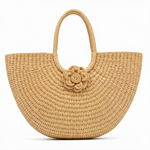

'results'

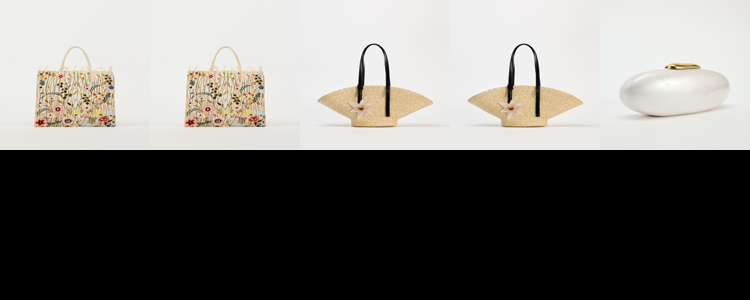

In [156]:
from IPython.display import display

#user_query = "I need something like this"
shoes = False
if shoes:
    user_query = "I need shoes like this"
    user_image = "./test/test_embellished_shoes.jpeg"
else:
    user_query = "I love this bag"
    user_image = "./test/test_straw_bag.jpeg"
    
match = get_best_match(user_query, unique_pairs_dict)
print(match)

filter_string = create_search_filter_string(match)

print(filter_string)

query_vectors = [extractor(user_image)]

results = client.search(
    collection_name=COLLECTION_IMAGES,  # target collection
    data=query_vectors,  # query vectors
    limit=5,  # number of returned entities
    output_fields=["name","category","subcategory", "image_path"],  # specifies fields to be returned
    filter=filter_string,
)

import ast
from IPython.display import display
images = []
# Extract the 'image_path' from each entry
image_paths = [item['entity']['image_path'] for item in results[0]]
# Print the image paths
for image_path in image_paths:
    print(image_path)

for image in image_paths:
        img = Image.open(image)
        img = img.resize((150, 150))
        images.append(img)

width = 150 * 5
height = 150 * 2
concatenated_image = Image.new("RGB", (width, height))

for idx, img in enumerate(images):
    x = idx % 5
    y = idx // 5
    concatenated_image.paste(img, (x * 150, y * 150))
display("query")
display(Image.open(user_image).resize((150, 150)))
display("results")
display(concatenated_image)

./zara_catalog/images/accessories_bag_Mother_of_Pearl_Style_Clutch.jpg
./zara_catalog/images/apparel_dress_Black_Polka-Dotted_Slip_Dress.jpg
./zara_catalog/images/accessories_bag_Embroidered_Fabric_Tote.jpg
./zara_catalog/images/footwear_shoes_Bow_Trim_Heeled_Shoes_in_Black.jpg
./zara_catalog/images/accessories_bag_Basket_Shoulder_Bag_with_Flower.jpg


'query'

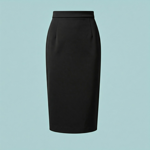

'results'

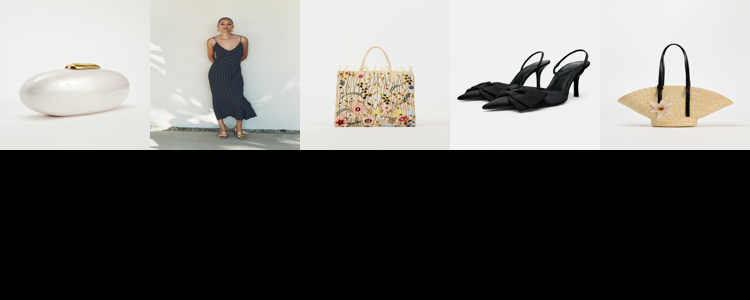

In [133]:
import ast
from IPython.display import display

# Extract the 'image_path' from each entry
image_paths = [item['entity']['image_path'] for item in formatted_data]
# Print the image paths
for image_path in image_paths:
    print(image_path)


# Extract the 'image_path' from each entry
image_paths = [item['entity']['image_path'] for item in formatted_data]

for image in image_paths:
        img = Image.open(image)
        img = img.resize((150, 150))
        images.append(img)

width = 150 * 5
height = 150 * 2
concatenated_image = Image.new("RGB", (width, height))

for idx, img in enumerate(images):
    x = idx % 5
    y = idx // 5
    concatenated_image.paste(img, (x * 150, y * 150))
display("query")
display(Image.open(query_image).resize((150, 150)))
display("results")
display(concatenated_image)